# Example code for OME pyramidal  writing

In [ ]:
import numpy as np

from skimage.data import binary_blobs
from bioio import BioImage
from bioio.types import PhysicalPixelSizes
from bioio_ome_zarr import OmeZarrWriter
import pyvips
from ome_types.model import OME, Image, Pixels, Channel

import os
import shutil

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# generate image data
mean_val=10
size_xy = 4096
size_c = 3
rng = np.random.default_rng(0)

In [3]:
# Create a non-random pattern with different frequencies for each channel
x = np.linspace(0, 2 * np.pi, size_xy)
y = np.linspace(0, 2 * np.pi, size_xy)

# Define different frequencies for each channel
frequencies = [1.0, 2.0, 3.0]

# Create a grid for the 4D sine wave pattern
x_grid, y_grid = np.meshgrid(x, y, indexing='ij')

# Create a sample data with different frequencies for each channel and time-dependent phase shift
sine_wave_data = []
for c in range(size_c):
    data_xy = np.sin(frequencies[c] * x_grid ) + np.cos(frequencies[c] * y_grid)
    sine_wave_data.append(data_xy.T)

sine_wave_data = np.stack(sine_wave_data, axis=0)

# Normalize data to uint8 range
sine_wave_data = ((sine_wave_data - sine_wave_data.min()) / (sine_wave_data.max() - sine_wave_data.min()) * 255).astype(np.uint8)

sine_wave_data.shape # CYX

(3, 4096, 4096)

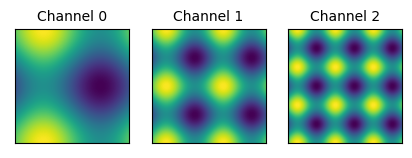

In [4]:
# Plot 2D slices for each time step
fig, axs = plt.subplots(1,size_c,figsize=(5, size_c*5))
for c in range(size_c):
    axs[c].imshow(sine_wave_data[c, :, :], cmap='viridis', extent=(0, size_xy, 0, size_xy), origin='lower')
    axs[c].set_xticks([])
    axs[c].set_yticks([])

    axs[c].set_title(f'Channel {c}', fontsize=10)  # Set xlabel for the last row

In [ ]:
pps = PhysicalPixelSizes(X=0.5, Y=0.5, Z=1.0)
channel_colors = ["FFFFFF","00FFFF","0000FF"]

int_color = [int(c, 16) for c in channel_colors]

## OME TIFF

In [6]:
# Reshape to (time * ZYX, channels)
image_data_reshaped = sine_wave_data.T # XYC
image_data_reshaped.shape

(4096, 4096, 3)

In [14]:
im_vips = pyvips.Image.new_from_memory(image_data_reshaped.transpose(1,0,2).reshape(-1,size_c).tobytes(), size_xy, size_xy, bands=size_c, format="uchar") # beware of format
im_vips = pyvips.Image.arrayjoin(im_vips.bandsplit(), across=1)
im_vips.set_type(pyvips.GValue.gint_type, "page-height", size_xy)
data_type = "uint8"
if (im_vips.interpretation=="grey16"):
    data_type = "uint16"

In [33]:
ome = OME()

img = Image(
    id="Image:0",
    name="resolution_1",
    pixels=Pixels(
        id="Pixels:0", type=data_type, dimension_order="XYZTC",
        size_c=size_c, size_x=size_xy, size_y=size_xy, size_z=1, size_t=1, 
        big_endian=False, metadata_only=True,
        physical_size_x=pps.X,
        physical_size_x_unit="µm",
        physical_size_y=pps.Y,
        physical_size_y_unit="µm",
        channels= [Channel(id=f"Channel:0:{i}", name=f"Ch_{i}", color=int_color[i]) for i in range(size_c)]
    )
)

ome.images.append(img)

In [10]:
def eval_cb(image, progress):
    pbar_filesave.update(progress.percent - pbar_filesave.n)

In [34]:
ome.to_xml()

'<OME xmlns="http://www.openmicroscopy.org/Schemas/OME/2016-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openmicroscopy.org/Schemas/OME/2016-06 http://www.openmicroscopy.org/Schemas/OME/2016-06/ome.xsd">\n  <Image ID="Image:0" Name="resolution_1">\n    <Pixels ID="Pixels:0" DimensionOrder="XYZTC" Type="uint8" BigEndian="false" SizeX="4096" SizeY="4096" SizeZ="1" SizeC="3" SizeT="1" PhysicalSizeX="0.5" PhysicalSizeXUnit="µm" PhysicalSizeY="0.5" PhysicalSizeYUnit="µm">\n      <Channel ID="Channel:0:0" Name="Ch_0" Color="16777215"/>\n      <Channel ID="Channel:0:1" Name="Ch_1" Color="65535"/>\n      <Channel ID="Channel:0:2" Name="Ch_2" Color="255"/>\n      <MetadataOnly/>\n    </Pixels>\n  </Image>\n</OME>\n'

In [35]:
im_vips.set_progress(True)

pbar_filesave = tqdm(total=100, unit="Percent", desc="Writing pyramidal BigTIFF", position=0, leave=True)
im_vips.signal_connect('eval', eval_cb)

im_vips.set_type(pyvips.GValue.gstr_type, "image-description", ome.to_xml())
im_vips.write_to_file(
    "../output/test.ome.tiff", 
    compression="lzw",
    tile=True, 
    tile_width=1024,
    tile_height=1024,
    pyramid=True,
    depth="onetile",
    # resunit='um',
    # xres=pps.X, 
    # yres=pps.Y, 
    subifd=True,
    bigtiff=True
    )

Writing pyramidal BigTIFF:  73%|███████▎  | 73/100 [00:00<00:00, 266.34Percent/s]

## OME ZARR

In [13]:
out_path = "../output/test.ome.zarr"

if os.path.exists(out_path):
    shutil.rmtree(out_path)

writer = OmeZarrWriter(out_path)

writer.write_image(
    sine_wave_data.T[np.newaxis,:,np.newaxis,:,:], 
    image_name="Image:0", 
    physical_pixel_sizes=pps,
    channel_names=["C00","C01","C02"],
    channel_colors=int_color,
    scale_num_levels=3,
    scale_factor=2.0,
    dimension_order="TCZYX"
    )

/home/jackyko/mambaforge/envs/myocardial/lib/python3.10/site-packages/skimage/transform/_warps.py:159: RuntimeWarning: divide by zero encountered in divide
  factors = np.divide(input_shape, output_shape)
Writing pyramidal BigTIFF: 100%|██████████| 100/100 [00:19<00:00, 433.77Percent/s]